# Tutorial: Running DePART within Python for Fractionation #

The tutorial covers the following parts:

1. Getting data from MaxQuant into Python
2. Generating the default list of features used by DePART
3. Fitting the Feed Forward Neural Net (FNN) to the Training data
4. Predicting new class labels on another data set and QC metrics
5. High-Level functions to simply CV, learn/predict


In [1]:
#necessary imports
import DePART.preprocessing.FeatureFactory as FF
import DePART.preprocessing.PrepFactory as PF
import DePART.reader.ReaderFactory as RF
import DePART.learning.models as LM
import DePART.learning.processing as LP

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, auc, mean_squared_error, r2_score, f1_score, accuracy_score

import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils

#set a seed
np.random.seed(42)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Getting data from MaxQuant 

In [3]:
#options
min_obs = 1
#infile = "C:\\Users\\hanjo\\ML\\DePART_New\\data\\evidence_SAX_Trost.txt"
infile = "C:\\Users\\Hanjo\\Spyder_DePART\\DePART\\data\\evidence_SAX_Trost.txt"
df_evidence = RF.MaxQuant_Reader(infile)
print (df_evidence.shape)

#select most intense
df_filter = PF.filter_low_int_ids(df_evidence)

#minimum obs filter per fraction
df_filter = PF.filter_obs(df_filter, min_obs=min_obs)

#get a minimal df for processing
df_meta, df = PF.to_minimal_df(df_filter)

(337832, 60)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


NRows BEFORE min obs filter: 59723
NRows AFTER min obs filter: 59297


## 2. Generating the default list of features used by DePART

In [4]:
#generate features
Generator = FF.FeatureGenerator()
ff_df = Generator.create_all_features(df)


300


C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["Sequence"] = df["Sequence"].apply(simply_alphabet).values


There were no identifyable amino acids/modifications in your data: . We cannot deal with these...


C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:533: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  count_df.set_value(ii, nterm, count_df.loc[ii][nterm]+1)
C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:540: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  count_df.set_value(ii, cterm, count_df.loc[ii][cterm]+1)


## 3. Fitting the Feed Forward Neural Net (FNN) to the Training data

In [5]:
#setttings
batch_size = 512
epochs = 50
nn_args = {"act":["swish", "swish", "swish"]}
###############################

#train and test split
train_df, valid_df = np.split(ff_df.sample(frac=1, random_state=42), 
                              [int(.75*len(ff_df))])

#format the dataframe for ML 
X_train_full, Seqs_train_full, y_train_full = LP.process_df(train_df)
X_valid_full, Seqs_valid_full, y_valid_full = LP.process_df(valid_df)    

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_full)

#output dims depending on the number of fractions
output_dims = len(np.unique(train_df.Fraction))
input_dims = X_train_full.shape[1]

nnmodel = LM.SAX_Model(output_dim=output_dims, input_dim=input_dims, **nn_args)
print (nnmodel.summary())
history = nnmodel.fit(np.array(X_train_full),
                      np_utils.to_categorical(encoder.transform(y_train_full)),
                      epochs=epochs, batch_size=batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                1435      
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 29)                1044      
Total para

## 4. Predicting new class labels on another data set

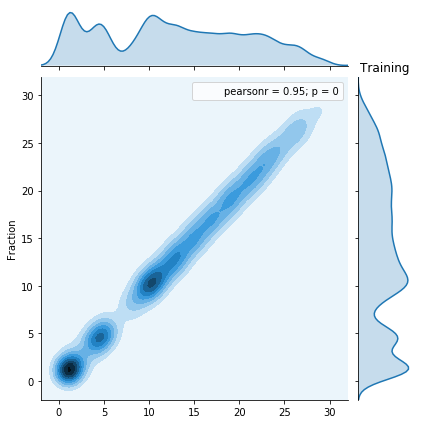

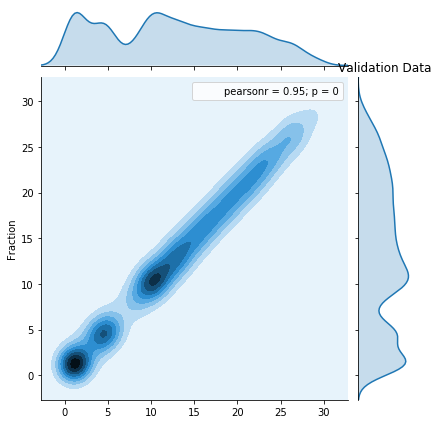

Training Accuracy: 0.67
Validation Accuracy: 0.65


In [6]:
#predictions, can be class labels or probabilities!
yhat_train_prob = nnmodel.predict(np.array(X_train_full))
yhat_train_disc = yhat_train_prob.argmax(axis=1) + 1

yhat_val_prob = nnmodel.predict(np.array(X_valid_full))
yhat_val_disc = yhat_val_prob.argmax(axis=1) + 1

sns.jointplot(yhat_train_disc, y_train_full, kind="kde")
plt.title("Training")
plt.show()

sns.jointplot(yhat_val_disc, y_valid_full, kind="kde")
plt.title("Validation Data")
plt.show()

print ("Training Accuracy: {:.2f}".format(accuracy_score(yhat_train_disc, y_train_full)))
print ("Validation Accuracy: {:.2f}".format(accuracy_score(yhat_val_disc, y_valid_full)))


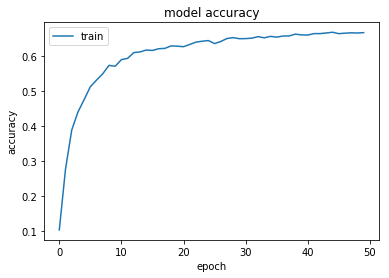

In [7]:
# we can also plot the history of the epochs along with the error metric (here, accuracy)
#compute some metrics

plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## 5. Higher-Level Functions
The previous functions all show to do the analysis step by step, however, there are also a few convencience functions that might be useful for cross-validation.

In [8]:
#cross-validation 
#uses the build in NN model, parameters can passed in a dictionary form
CV_res = LP.cross_validation(train_df, valid_df, name="FNN",
                              nkfold=5, n_jobs=5, nn_args={"act":["swish","swish", "swish"]},
                              use_joblib=False, epochs=25, 
                              batch_size=256)

#now train on all data and do the validation
res_df, nnmodel, history = \
        LP.train_validation(traindf, valdf, epochs=25, 
                         batch_size=256, plot=False,
                         nn_args={})

Training Size: (44472, 216)
Validation Size: (14825, 216)
Overlapping indices:
[]
Overlapping Sequences:
[]
Epoch 1/25
35577/35577 [==============================] - 1s 18us/step - loss: 2.8233 - categorical_accuracy: 0.1632 - acc: 0.1632
Epoch 2/25
35577/35577 [==============================] - 0s 13us/step - loss: 2.0051 - categorical_accuracy: 0.3667 - acc: 0.3667
Epoch 3/25
35577/35577 [==============================] - 0s 14us/step - loss: 1.7618 - categorical_accuracy: 0.4434 - acc: 0.4434
Epoch 4/25
35577/35577 [==============================] - 1s 14us/step - loss: 1.6194 - categorical_accuracy: 0.4969 - acc: 0.4969
Epoch 5/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.5253 - categorical_accuracy: 0.5266 - acc: 0.5266
Epoch 6/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.4540 - categorical_accuracy: 0.5527 - acc: 0.5527
Epoch 7/25
35577/35577 [==============================] - 0s 14us/step - loss: 1.4132 - categorical_accura

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/25
35577/35577 [==============================] - 1s 18us/step - loss: 2.8127 - categorical_accuracy: 0.1659 - acc: 0.1659
Epoch 2/25
35577/35577 [==============================] - 0s 13us/step - loss: 2.0447 - categorical_accuracy: 0.3480 - acc: 0.3480
Epoch 3/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.8122 - categorical_accuracy: 0.4183 - acc: 0.4183
Epoch 4/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.6623 - categorical_accuracy: 0.4691 - acc: 0.4691
Epoch 5/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.5748 - categorical_accuracy: 0.5070 - acc: 0.5070
Epoch 6/25
35577/35577 [==============================] - 0s 13us/step - loss: 1.5078 - categorical_accuracy: 0.5328 - acc: 0.5328
Epoch 7/25
35577/35577 [==============================] - 0s 14us/step - loss: 1.4592 - categorical_accuracy: 0.5537 - acc: 0.5537
Epoch 8/25
35577/35577 [==============================] - 1s 15us/step - loss: 1.42

35578/35578 [==============================] - 0s 13us/step - loss: 1.2648 - categorical_accuracy: 0.6118 - acc: 0.6118
Epoch 13/25
35578/35578 [==============================] - 0s 13us/step - loss: 1.2462 - categorical_accuracy: 0.6186 - acc: 0.6186
Epoch 14/25
35578/35578 [==============================] - 1s 14us/step - loss: 1.2418 - categorical_accuracy: 0.6150 - acc: 0.6150
Epoch 15/25
35578/35578 [==============================] - 0s 14us/step - loss: 1.2251 - categorical_accuracy: 0.6258 - acc: 0.6258 0s - loss: 1.2166 - categorical_accuracy: 0.6270 - a
Epoch 16/25
35578/35578 [==============================] - 0s 13us/step - loss: 1.2066 - categorical_accuracy: 0.6308 - acc: 0.6308
Epoch 17/25
35578/35578 [==============================] - 0s 13us/step - loss: 1.2017 - categorical_accuracy: 0.6344 - acc: 0.6344
Epoch 18/25
35578/35578 [==============================] - 0s 13us/step - loss: 1.1964 - categorical_accuracy: 0.6325 - acc: 0.6325
Epoch 19/25
35578/35578 [==========

NameError: name 'traindf' is not defined

In [9]:
#now print the results
CV_res
CV_res["Accuracy"]

,mean,sem
Method,,
FNN_Test,0.634,0.003
FNN_Train,0.652,0.006


In [38]:
res_df

,MSA,MSE,R^2,F1 (weighted),Accuracy,mean. dist,std. dist,AUC,0-off-pred,1-off-pred,2-off-pred,3-off-pred,5-off-pred,Correlation,Method
0,0.839922,6.72578,0.893285,0.642814,0.657875,0.839922,2.45363,412.5,65.7875,91.1427,93.7961,94.9092,95.6287,0.947768,keras_Train
0,0.877369,7.08472,0.887733,0.627248,0.642293,0.877369,2.51296,400,64.2293,90.6779,93.6324,94.9005,95.5211,0.945212,keras_Valid


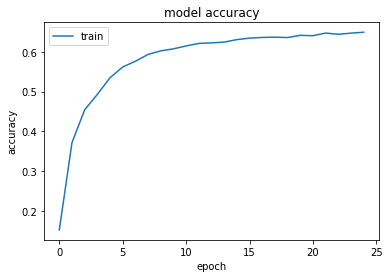

In [40]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
featur